### Post-Implementation Testing 
---

In typical post-implementaion testing, we have two sources of data which should have the same distribution. Unfortunately, it is often difficult to align the two, led to the need of this library.

For one, it is foremost importance to measure the prediction results. Thus we want ways to compare output distributions. 
* distr plot of the output classes
* plot differences between classes

For feature analysis, we should measure PSI and produce side-by-side pandas-profiles 

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
from train import features, preprocess
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
# get data
prod_df = pkl.load(open('../../data/production-results/2020-08-05_full-customer-model-data.pickle', 'rb'))
prod_df['score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)

modeling_df = pd.read_feather('../../data/combined_all_features/combined_1598485606.feather')
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-08-04')]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']

In [3]:
# produce scores
model = pkl.load(open('../../models/customer_risk_target_from_gitlab.pkl', 'rb'))

In [4]:
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

In [ ]:
# trimming dfs
id_dict = get_overlap_and_diff(prod_df.party_id, modeling_df.party_id)
shared_id = id_dict['shared']
shared_cols = modeling_df.columns.intersection(prod_df.columns)
modeling_df = modeling_df[modeling_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')
prod_df = prod_df[prod_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')

#### Functionalities
---

In [ ]:
combined_df = get_combined_dfs(modeling_df, prod_df, 'party_id')

((284419, 112), (284419, 52))

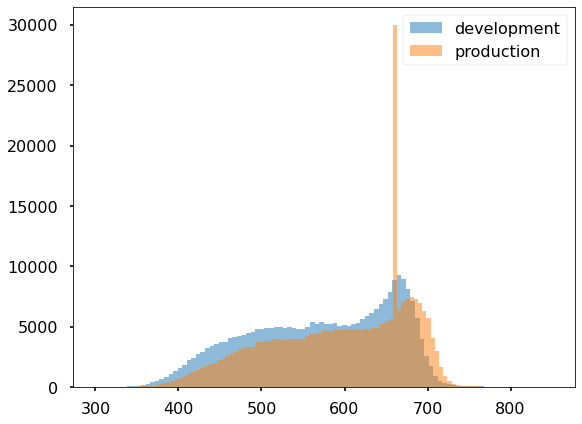

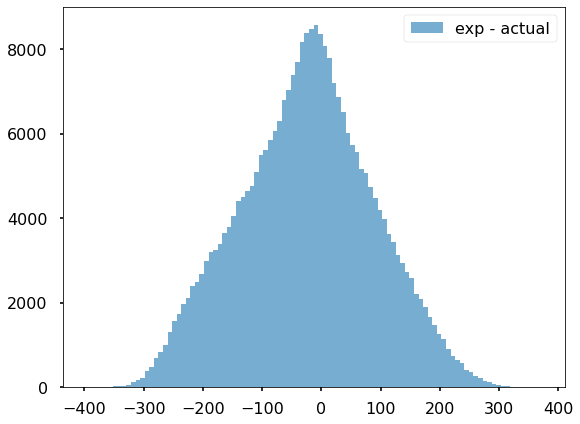

In [11]:
_ = plot_score_dist(modeling_df.score, prod_df.score, bins=100)
psi_df = get_psi(modeling_df[shared_cols], prod_df[shared_cols])

_ = plot_difference(modeling_df.score, prod_df.score, bins=100)
modeling_df.shape, prod_df.shape

In [29]:
report = get_feature_comparison_report(modeling_df, prod_df, 
                                       'party_id', title='post-imp-report', 
                                       cols=psi_df.head(10).feature.tolist())

In [19]:
report